# LSTM

**TODO**
- hidden zurückgeben und übergeben bekommen in der forward
- hidden mit 0 initialisieren

### CONFIG

In [ ]:
CFG = {
    "batch_size": 256,
    "input_size": 1,
    "input_seq": 6*3,
    "output_seq": 3,
    "epochs": 50,
    "lr": 0.001
}

### MODULES

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

### LOAD DATA

In [3]:
df = pd.read_csv("appliances_energy_prediction.csv")
df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


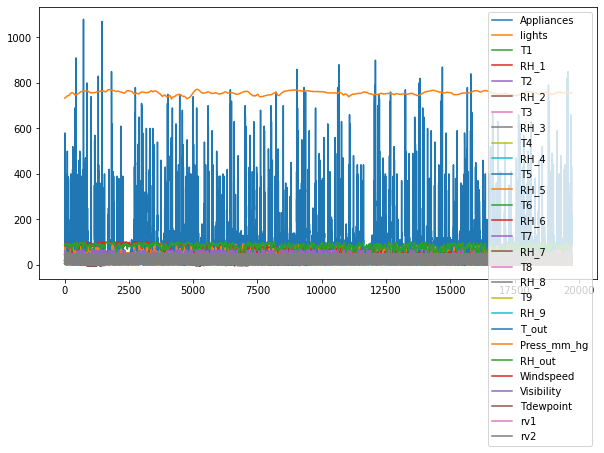

In [4]:
df.plot(figsize=(10, 5))

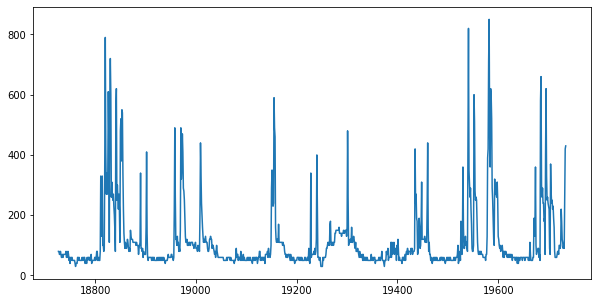

In [5]:
df["Appliances"].tail(6*24*7).plot(figsize=(10, 5))

### GENERATE SEQUENCES

In [6]:
def gen_seq(a, input_seq, output_seq):
    xs, ys = [], []
    for i in range(len(a)-input_seq-output_seq+1):
        x = a[i:i+input_seq]
        y = a[i+input_seq:i+input_seq+output_seq]
        xs.append(x)
        ys.append(y)
    
    return np.stack(xs), np.stack(ys)


x, y = gen_seq(df["Appliances"].to_numpy(), CFG["input_seq"], CFG["output_seq"])
x.shape, y.shape

((19715, 18), (19715, 3))

### DATA SPLIT

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=False)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((11829, 18), (3943, 18), (3943, 18), (11829, 3), (3943, 3), (3943, 3))

### DATASET

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        sample, label = self.x[idx], self.y[idx]
        sample, label = torch.tensor(sample), torch.tensor(label)
        return sample, label
    
    
data = {
    "train": Dataset(x_train, y_train),
    "val": Dataset(x_val, y_val),
    "test": Dataset(x_test, y_test)
}

data_loader = {
    "train": torch.utils.data.DataLoader(data["train"], batch_size=CFG["batch_size"], pin_memory=False, shuffle=False),
    "val": torch.utils.data.DataLoader(data["val"], batch_size=CFG["batch_size"], pin_memory=False, shuffle=False),
    "test": torch.utils.data.DataLoader(data["test"], batch_size=CFG["batch_size"], pin_memory=False, shuffle=False)
}

len(data["train"]), len(data["val"]), len(data["test"])

(11829, 3943, 3943)

### MODEL

In [9]:
class Net(nn.Module):
    def __init__(self, input_size, input_seq, hidden_size, num_layers, output_seq):
        super(Net, self).__init__()
        self.input_size = input_size
        self.input_seq = input_seq
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_seq = output_seq
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.l1 = nn.Linear(hidden_size, 128)
        self.output = nn.Linear(128, output_seq)
        
    def forward(self, x):
        x, hidden = self.lstm(x)
        x = x[:,-1,:]
        x = F.relu(self.l1(x))
        x = self.output(x)
        return x
    
    
net = Net(CFG["input_size"], CFG["input_seq"], 128, 2, CFG["output_seq"]).float()
net

Net(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (l1): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=3, bias=True)
)

### FIT

In [10]:
def train_model(model, criterion=None, optimizer=None, epochs=10):
    metrics = {
        "train_loss": [],
        "val_loss": []
    }
    
    for epoch in range(epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            t = tqdm(data_loader[phase], total=len(data_loader[phase]), leave=True, position=0)
            t.set_description(f"{phase.upper()} epoch {epoch+1}")
                
            epoch_loss = []
            epoch_score = []
            
            for step, samples in enumerate(t):
                optimizer.zero_grad()
                
                inputs, targets = samples
                inputs, targets = inputs.float().view(inputs.size(0), inputs.size(1), 1), targets.float()#.view(targets.shape[0], -1)
                outputs = model(inputs)

                loss = criterion(outputs, targets)

                if phase == "train":
                    loss.backward()
                    optimizer.step()
                  
                epoch_loss.append(loss.item())
                
                t.set_description(f"{phase.upper()}\t ({epoch+1}) loss {np.mean(epoch_loss):.2f}\t rmse {np.sqrt(np.mean(epoch_loss)):.2f}")
                
            epoch_loss = np.mean(epoch_loss)
            metrics[f"{phase}_loss"].append(epoch_loss)
            
            
    return metrics


criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=CFG["lr"])
metrics = train_model(net, criterion=criterion, optimizer=optimizer, epochs=CFG["epochs"])

VAL	 (50) loss 6238.00	 rmse 78.98: 100%|██████████| 16/16 [00:01<00:00, 15.30it/s] 


### EVALUATION

In [11]:
net.eval()

inputs = torch.tensor(x_test).view(x_test.shape[0], x_test.shape[1], 1).float()
y_pred = net(inputs).detach().numpy()
y_pred

array([[406.11337 , 293.47366 , 234.53802 ],
       [245.3189  , 212.8743  , 195.11002 ],
       [298.12296 , 249.03555 , 222.25662 ],
       ...,
       [120.25483 , 139.57867 , 148.39554 ],
       [131.29845 , 148.77628 , 156.5347  ],
       [121.713196, 141.16092 , 150.02197 ]], dtype=float32)

**One step ahead forecast**

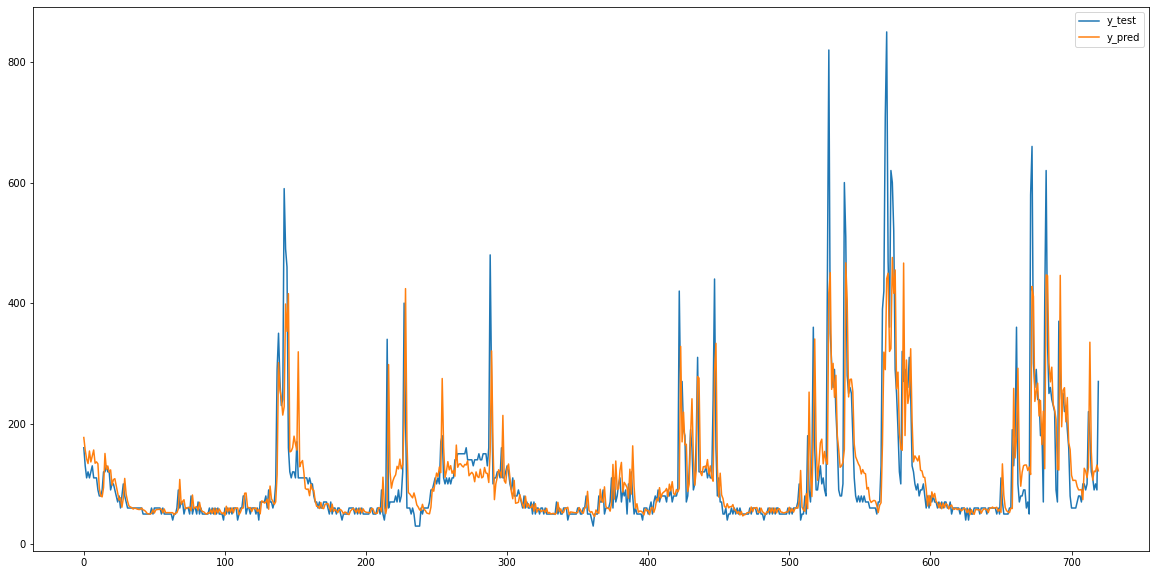

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_test.squeeze()[:,0][-24*30:], label="y_test")
ax.plot(y_pred[:,0][-24*30:], label="y_pred")
ax.legend()
plt.show()

**Complete window forecast**

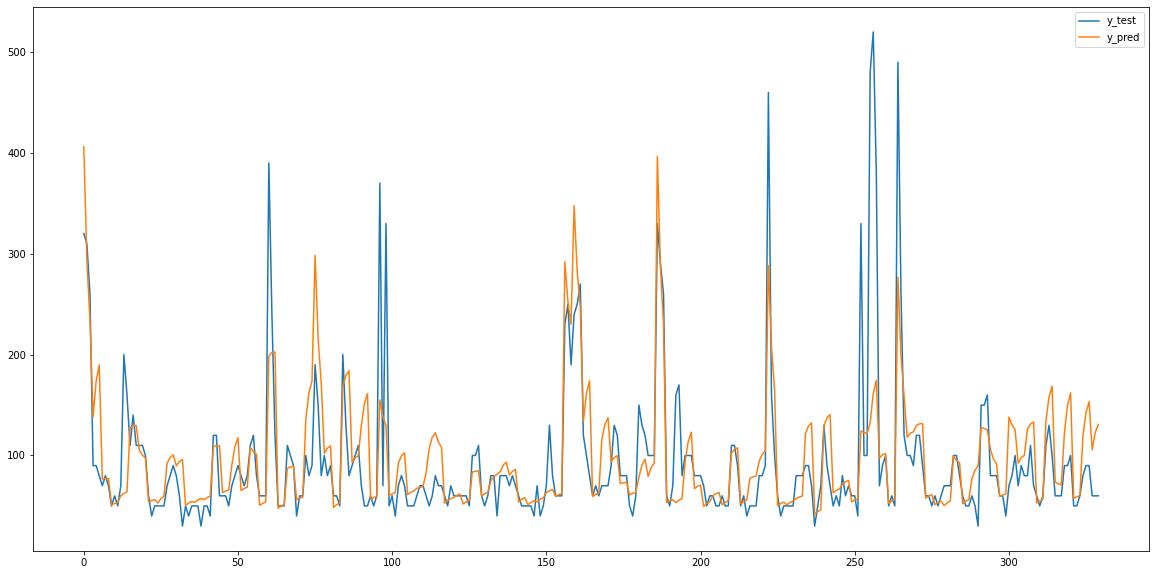

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(y_test[::36].reshape(-1)[-24*30:], label="y_test")
ax.plot(y_pred[::36].reshape(-1)[-24*30:], label="y_pred")
ax.legend()
plt.show()

**one window forecast example**

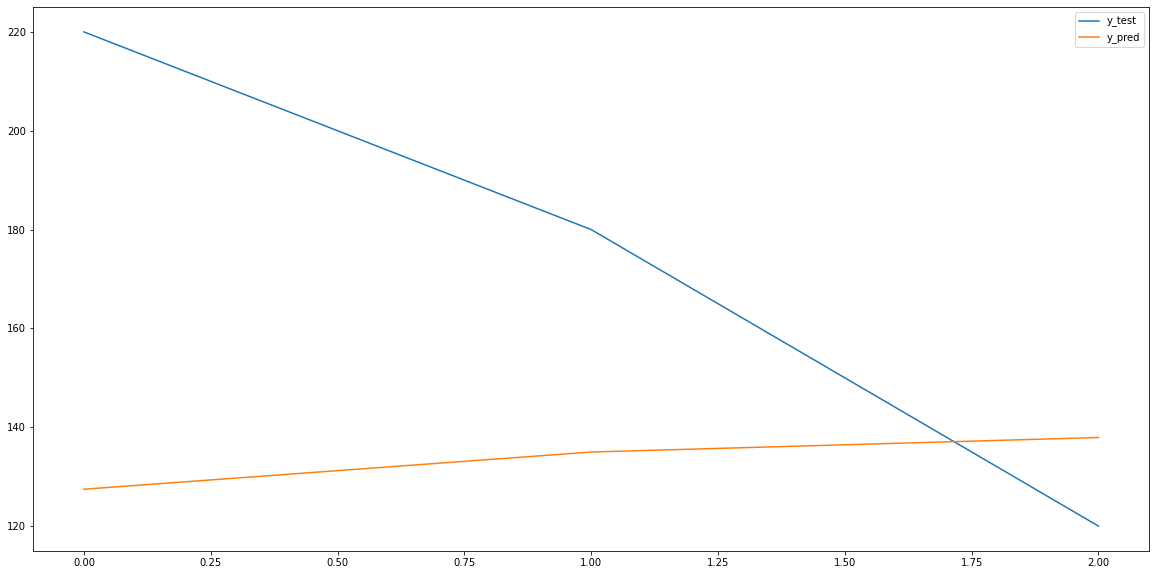

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(y_test[-8], label="y_test")
ax.plot(y_pred[-8], label="y_pred")
ax.legend()
plt.show()